# Classification using GIST Features

## Initial Setup

In [1]:
from __future__ import division
from PIL import Image
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import gist
import imageutils

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### Load Images into a Matrix

In [2]:
base_dir = 'square_images128_traintest'
#(X_all, y_all, classes, class_dict) = imageutils.load_data(base_dir)
(X_train, y_train, classes, class_dict) = imageutils.load_data(base_dir + '/train')
(X_test, y_test, _, _) = imageutils.load_data(base_dir + '/test')
image_height = X_train.shape[1]
image_width = X_train.shape[2]
print(X_train.shape)
print(classes)

(1020, 128, 128, 3)
['bluebell', 'buttercup', 'colts_foot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lily_valley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


### Define feature extraction functions

In [3]:
def extract_all_gist_features(X):
    num_examples = X.shape[0]
    features = []
    for index in range(num_examples):
        feature_vec = gist.extract(X[index].astype('uint8'))
        features.append(feature_vec)
    
    X_features = np.vstack(features)
    return X_features

In [4]:
def extract_gist(I):
    return gist.extract(I.astype('uint8'))

In [5]:
def tiny_image(image_array, width=16, height=16):
    I = Image.fromarray(image_array.astype('uint8'))
    I_tiny = I.resize((width, height))
    I_tiny_array = np.array(I_tiny).astype('float')
    return np.reshape(I_tiny_array, width * height * 3)

In [6]:
def color_histogram_rgb(image_array):
    h, edges = np.histogramdd(image_array.reshape(-1,3), 8, normed=True, range=[(0,255), (0,255), (0,255)])
    return h.flatten()

In [7]:
color_histogram_rgb(X_train[0]).shape

(512,)

In [8]:
def extract_features(X, feature_functions):
    num_examples = X.shape[0]
    feature_rows = []
    for index in range(num_examples):
        I = X[index]
        features = []
        for feature_func in feature_functions:
            feature_vec = feature_func(I)
            features.append(feature_vec)
        
        example_features_row_vec = np.hstack(features)
        feature_rows.append(example_features_row_vec)
    
    X_features = np.vstack(feature_rows)
    return X_features

### Extract features and concatenates them

In [9]:
from features import hog_feature, color_histogram_hsv

num_color_bins = 100 # Number of bins in the color histogram
#feature_fns = [extract_gist, hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist]
#feature_fns = [lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist, tiny_image]
feature_fns = [extract_gist, tiny_image, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_features = extract_features(X_train, feature_fns)
X_test_features = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_features = np.mean(X_train_features, axis=0)
mean_features = np.expand_dims(mean_features, axis=0)
X_train_features -= mean_features
X_test_features -= mean_features

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_features = np.std(X_train_features, axis=0)
std_features = np.expand_dims(std_features, axis=0)
X_train_features /= std_features
X_test_features /= std_features

# Preprocessing: Add a bias dimension
X_train_features = np.hstack([X_train_features, np.ones((X_train_features.shape[0], 1))])
X_test_features = np.hstack([X_test_features, np.ones((X_test_features.shape[0], 1))])

print(X_train_features.shape)

(1020, 1829)


## Training models
### Naïve Bayes
There are no variables to cross validate here

In [10]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train_features, y_train).predict(X_test_features)
print('Naive Bayes accuracy on full training set: %f' % (np.mean(y_pred == y_test)))

Naive Bayes accuracy on full training set: 0.561765


In [11]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

gnb_cv_accuracies = cross_val_score(gnb, X_train_features, y_train, cv=cv, n_jobs=7)
print('Average Naive Bayes accuracy: %f' % gnb_cv_accuracies.mean())

Average Naive Bayes accuracy: 0.499020


### Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_split=16)
y_pred = dtc.fit(X_train_features, y_train).predict(X_test_features)
print('Decision Tree accuracy: %f' % (np.mean(y_pred == y_test)))

Decision Tree accuracy: 0.420588


In [13]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

test_values = [2, 4, 8, 16, 32, 64, 128, 256, 512]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

dtc_avg_accuracies = []
for v in test_values:
    dtc = DecisionTreeClassifier(min_samples_split=v)
    dtc_cv_accuracies = cross_val_score(dtc, X_train_features, y_train, cv=cv, n_jobs=7)
    dtc_cv_acc_mean = dtc_cv_accuracies.mean()
    dtc_avg_accuracies.append(dtc_cv_acc_mean)
    print 'Average accuracy with ' + str(v) + ' : ' + str(dtc_cv_acc_mean)
    

Average accuracy with 2 : 0.344117647059
Average accuracy with 4 : 0.337254901961
Average accuracy with 8 : 0.345098039216
Average accuracy with 16 : 0.35
Average accuracy with 32 : 0.361764705882
Average accuracy with 64 : 0.341176470588
Average accuracy with 128 : 0.266666666667
Average accuracy with 256 : 0.197058823529
Average accuracy with 512 : 0.11862745098


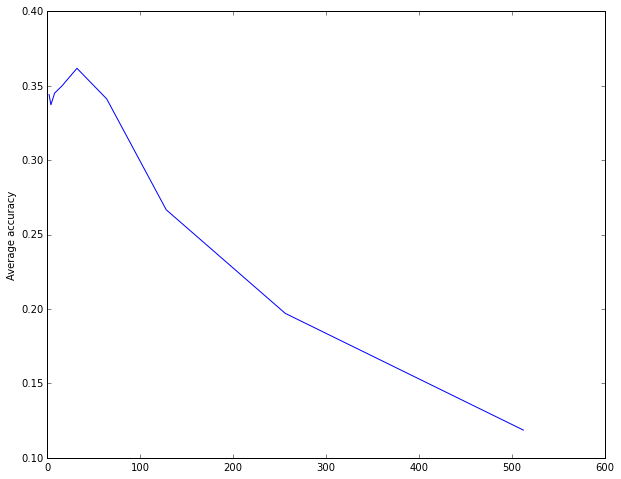

In [14]:
import matplotlib.pyplot as plt

plt.plot(test_values, dtc_avg_accuracies)
plt.ylabel('Average accuracy')
plt.show()

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1024, min_samples_split=2, n_jobs=-1)
y_pred = rfc.fit(X_train_features, y_train).predict(X_test_features)
print('Random Forest accuracy: %f' % (np.mean(y_pred == y_test)))

Random Forest accuracy: 0.714706


In [16]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

test_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

rfc_avg_accuracies = []
for v in test_values:
    rfc = RandomForestClassifier(n_estimators=v, min_samples_split=2, n_jobs=-1)
    rfc_cv_accuracies = cross_val_score(rfc, X_train_features, y_train, cv=cv, n_jobs=7)
    rfc_cv_acc_mean = rfc_cv_accuracies.mean()
    rfc_avg_accuracies.append(rfc_cv_acc_mean)
    print 'Average accuracy with ' + str(v) + ' : ' + str(rfc_cv_acc_mean)
    

Average accuracy with 1 : 0.28137254902
Average accuracy with 2 : 0.275490196078
Average accuracy with 4 : 0.347058823529
Average accuracy with 8 : 0.405882352941
Average accuracy with 16 : 0.461764705882
Average accuracy with 32 : 0.529411764706
Average accuracy with 64 : 0.56862745098
Average accuracy with 128 : 0.596078431373
Average accuracy with 256 : 0.610784313725
Average accuracy with 512 : 0.630392156863
Average accuracy with 1024 : 0.630392156863
Average accuracy with 2048 : 0.623529411765


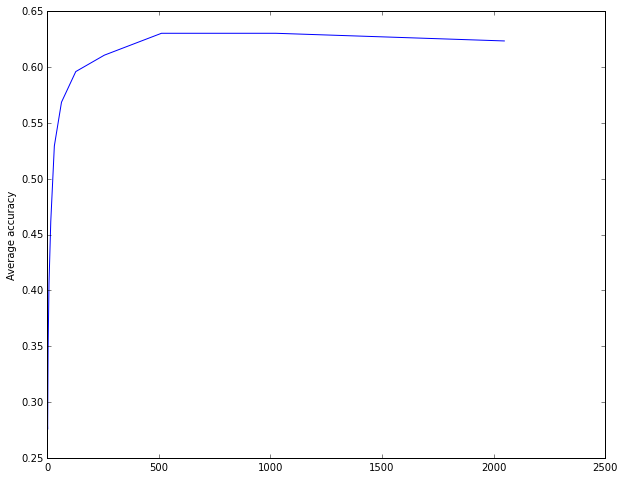

In [17]:
import matplotlib.pyplot as plt

plt.plot(test_values, rfc_avg_accuracies)
plt.ylabel('Average accuracy')
plt.show()

In [18]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

test_values = [2, 4, 8, 16, 32, 64, 128]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

rfc_avg_accuracies = []
for v in test_values:
    rfc = RandomForestClassifier(n_estimators=512, min_samples_split=v, n_jobs=-1)
    rfc_cv_accuracies = cross_val_score(rfc, X_train_features, y_train, cv=cv, n_jobs=7)
    rfc_cv_acc_mean = rfc_cv_accuracies.mean()
    rfc_avg_accuracies.append(rfc_cv_acc_mean)
    print 'Average accuracy with ' + str(v) + ' : ' + str(rfc_cv_acc_mean)

Average accuracy with 2 : 0.614705882353
Average accuracy with 4 : 0.61862745098
Average accuracy with 8 : 0.613725490196
Average accuracy with 16 : 0.607843137255
Average accuracy with 32 : 0.590196078431
Average accuracy with 64 : 0.538235294118
Average accuracy with 128 : 0.466666666667


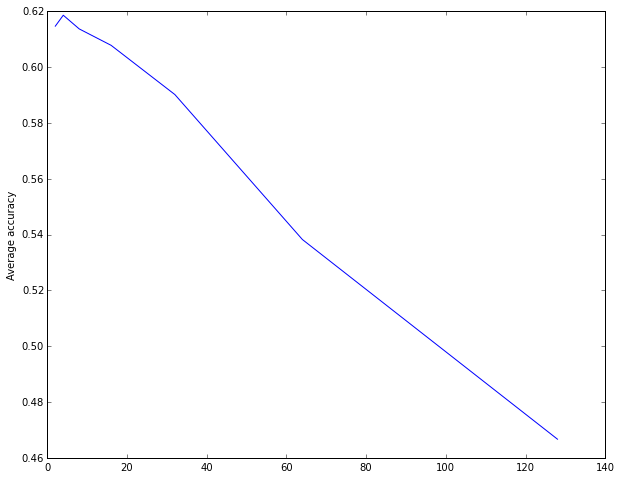

In [19]:
import matplotlib.pyplot as plt

plt.plot(test_values, rfc_avg_accuracies)
plt.ylabel('Average accuracy')
plt.show()

### Gradient Boost

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=512, max_features='auto')
y_pred = gbc.fit(X_train_features, y_train).predict(X_test_features)
print('Gradient Boosting accuracy: %f' % (np.mean(y_pred == y_test)))

Gradient Boosting accuracy: 0.688235


In [21]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

n_values = [32, 64, 128, 256, 512]
rate_values = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

gbc_avg_accuracies = []
for n in n_values:
    n_avgs = []
    for r in rate_values:
        gbc = GradientBoostingClassifier(learning_rate=r, n_estimators=n, max_features='auto')
        gbc_cv_accuracies = cross_val_score(gbc, X_train_features, y_train, cv=cv, n_jobs=-1)
        gbc_cv_acc_mean = gbc_cv_accuracies.mean()
        n_avgs.append(gbc_cv_acc_mean)
        print 'Average accuracy with ' + str(n) + ', ' + str(r) + ' : ' + str(gbc_cv_acc_mean)
    gbc_avg_accuracies.append(n_avgs)

Average accuracy with 32, 0.01 : 0.567647058824
Average accuracy with 32, 0.02 : 0.569607843137
Average accuracy with 32, 0.04 : 0.564705882353
Average accuracy with 32, 0.08 : 0.560784313725
Average accuracy with 32, 0.16 : 0.517647058824
Average accuracy with 32, 0.32 : 0.471568627451
Average accuracy with 64, 0.01 : 0.578431372549
Average accuracy with 64, 0.02 : 0.589215686275
Average accuracy with 64, 0.04 : 0.589215686275
Average accuracy with 64, 0.08 : 0.589215686275
Average accuracy with 64, 0.16 : 0.555882352941
Average accuracy with 64, 0.32 : 0.526470588235
Average accuracy with 128, 0.01 : 0.595098039216
Average accuracy with 128, 0.02 : 0.597058823529
Average accuracy with 128, 0.04 : 0.596078431373
Average accuracy with 128, 0.08 : 0.595098039216
Average accuracy with 128, 0.16 : 0.585294117647
Average accuracy with 128, 0.32 : 0.51568627451
Average accuracy with 256, 0.01 : 0.605882352941
Average accuracy with 256, 0.02 : 0.597058823529
Average accuracy with 256, 0.04 :

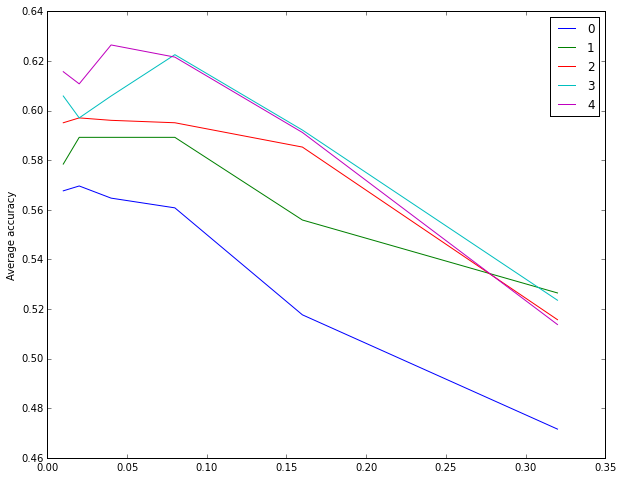

In [22]:
import matplotlib.pyplot as plt

for i, n in enumerate(gbc_avg_accuracies):
    plt.plot(rate_values, n, label=str(i))

plt.legend()
plt.ylabel('Average accuracy')
plt.show()

### Adaboost

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(min_samples_split=16)

abc = AdaBoostClassifier(algorithm='SAMME', base_estimator=dtc, n_estimators=40, learning_rate=1.0)
y_pred = abc.fit(X_train_features, y_train).predict(X_test_features)
print('Ada Boosting accuracy: %f' % (np.mean(y_pred == y_test)))

Ada Boosting accuracy: 0.620588


In [40]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

# imports for calling the base classfifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

bases = {
    'stump' : DecisionTreeClassifier(max_depth=2),
    'dtc' : DecisionTreeClassifier(min_samples_split=16, max_features='auto'),
    'svm' : SVC(kernel='linear', class_weight='auto')
}

n_estimators_values = [2, 4, 8, 16, 32, 64]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=5, shuffle=True, random_state=None)

gbc_avg_accuracies = []
for bs, bo in bases.items():
    n_avgs = []
    for n in n_estimators_values:
        gbc = AdaBoostClassifier(algorithm='SAMME', base_estimator=bo, n_estimators=n, learning_rate=1.0)
        gbc_cv_accuracies = cross_val_score(gbc, X_train_features, y_train, cv=cv, n_jobs=-1)
        gbc_cv_acc_mean = gbc_cv_accuracies.mean()
        n_avgs.append(gbc_cv_acc_mean)
        print 'Average accuracy for ' + bs + ', with ' + str(n) + ' : ' + str(gbc_cv_acc_mean)
    gbc_avg_accuracies.append(n_avgs)

Average accuracy for dtc, with 2 : 0.229411764706
Average accuracy for dtc, with 4 : 0.299019607843
Average accuracy for dtc, with 8 : 0.348039215686
Average accuracy for dtc, with 16 : 0.385294117647
Average accuracy for dtc, with 32 : 0.46568627451
Average accuracy for dtc, with 64 : 0.51862745098
Average accuracy for svm, with 2 : 0.633333333333
Average accuracy for svm, with 4 : 0.606862745098
Average accuracy for svm, with 8 : 0.608823529412
Average accuracy for svm, with 16 : 0.617647058824
Average accuracy for svm, with 32 : 0.600980392157
Average accuracy for svm, with 64 : 0.595098039216
Average accuracy for stump, with 2 : 0.158823529412
Average accuracy for stump, with 4 : 0.144117647059
Average accuracy for stump, with 8 : 0.233333333333
Average accuracy for stump, with 16 : 0.28431372549
Average accuracy for stump, with 32 : 0.335294117647
Average accuracy for stump, with 64 : 0.344117647059


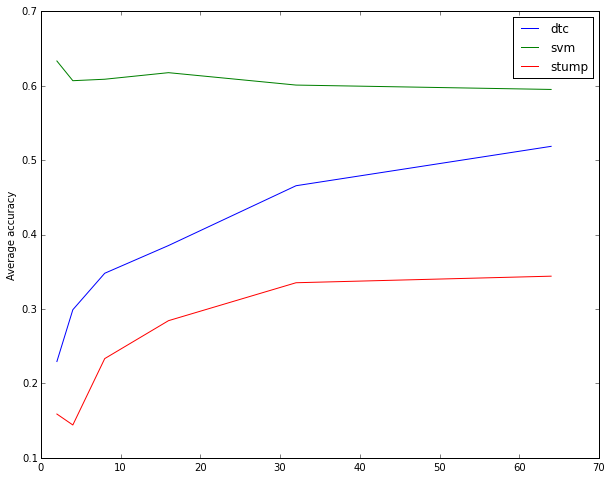

In [41]:
import matplotlib.pyplot as plt

base_strs = bases.keys()

for i, n in enumerate(gbc_avg_accuracies):
    plt.plot(n_estimators_values, n, label=base_strs[i])

plt.legend()
plt.ylabel('Average accuracy')
plt.show()

In [24]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', class_weight='auto')
svm.fit(X_train_features, y_train)

y_pred = svm.predict(X_test_features)
print('SVM accuracy: %f' % (np.mean(y_pred == y_test)))

SVM accuracy: 0.708824


In [25]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

svm_cv_accuracies = cross_val_score(svm, X_train_features, y_train, cv=cv, n_jobs=7)
print(svm_cv_accuracies)

[ 0.56862745  0.69607843  0.71568627  0.61764706  0.61764706  0.61764706
  0.61764706  0.6372549   0.76470588  0.51960784]
